
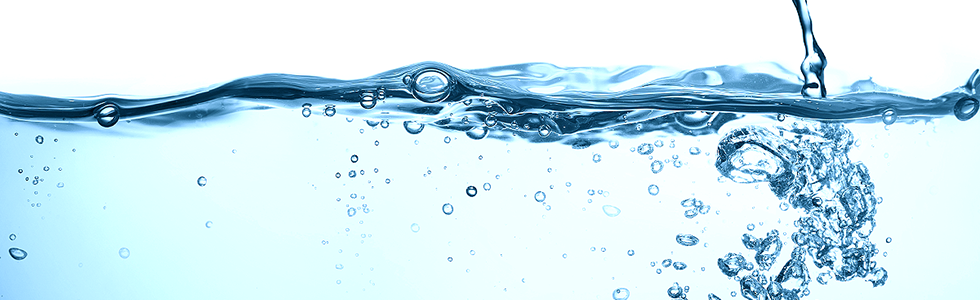

# Introduction

## Context
Access to safe drinking-water is essential to health, a basic human right and a component of effective policy for health protection. This is important as a health and development issue at a national, regional and local level. In some regions, it has been shown that investments in water supply and sanitation can yield a net economic benefit, since the reductions in adverse health effects and health care costs outweigh the costs of undertaking the interventions.


**Water Quality Features**


1. **ph**: pH of 1. water (0 to 14).

2. **Hardness**: Capacity of water to precipitate soap in mg/L.

3. **Solids**: Total dissolved solids in ppm.

4. **Chloramines**: Amount of Chloramines in ppm.

5. **Sulfate**: Amount of Sulfates dissolved in mg/L.

6. **Conductivity**: Electrical conductivity of water in μS/cm.

7. **Organic_carbon**: Amount of organic carbon in ppm.

8. **Trihalomethanes**: Amount of Trihalomethanes in μg/L.

9. **Turbidity**: Measure of light emiting property of water in NTU.

10. **Potability**: Indicates if water is safe for human consumption. Potable - 1 and Not potable - 0

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Basic Libraries
import numpy as np
import pandas as pd
from warnings import filterwarnings
from collections import Counter

# Visualizations Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.offline as pyo
import plotly.express as px
import plotly.graph_objs as go
pyo.init_notebook_mode()
import plotly.figure_factory as ff
import missingno as msno

# Data Pre-processing Libraries
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE

# Modelling Libraries
from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier,PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB
from sklearn.ensemble import VotingClassifier

# Evaluation & CV Libraries
from sklearn.metrics import precision_score,accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold
from xgboost.sklearn import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Exploratory Data Analysis 

In [ ]:
data = pd.read_csv('../input/water-potability/water_potability.csv')

In [ ]:
data.head(10)

### Missing data and numbers are decimals 

We see that there is Nah in Ph, Sulfate and other features. We will deal with the missing data later.

We see that most numbers have many decimals. We will round them up so we they are easy to read

In [ ]:
data.round()

## Visualizations

### Pair plot
Let's make plots to check whether there are high correlation between each features. 

In [ ]:
sns.pairplot(data, hue = "Potability")

We can see that cach feature dont have high correlation. Potability-"0" has more data than "1"

### Heatmap

Let's confirm the correlation between each features

In [ ]:
corr = data.drop("Potability", axis=1).corr()

corr

In [ ]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(corr, annot=True,  linewidths=.5, ax=ax)

Let's confirm the correlation between the target-"Potability" and each feature

In [ ]:
heatmap = sns.heatmap(data.corr()[['Potability']].sort_values(by='Potability', ascending = False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title("Features correlation with Potability", fontdict = {'fontsize':20}, pad=30);
heatmap.figure.set_size_inches(6,6)

As we can see the graph above, each feature does not produce high correlation. The highest correlation features are Solids and Organic_carbon

## Missing Data

Let's check a number of missing data of each feature 

In [ ]:
data.isnull().sum()

PH, Sulfate and Trihalomethanes have missing data. 

We are going to fill them with random number that are ranged from (mean + std) to (mean - std). 

In [ ]:
# Create mean and std
ph_mean = data['ph'].mean()
Sulfate_mean = data['Sulfate'].mean()
Trihalomethanes_mean = data['Trihalomethanes'].mean()

ph_std = data['ph'].std()
Sulfate_std = data['Sulfate'].std()
Trihalomethanes_std = data['Trihalomethanes'].std()

# Apply random number that are ranged from (mean + std) to (mean - std)
is_null_ph = data["ph"].isnull().sum()
rand_ph = np.random.randint(ph_mean - ph_std, ph_mean + ph_std, size = is_null_ph )
ph_slice = data['ph'].copy()
ph_slice[np.isnan(ph_slice)] = rand_ph
data['ph'] = ph_slice


is_null_Sulfate = data["Sulfate"].isnull().sum()
rand_Sulfate = np.random.randint(Sulfate_mean - Sulfate_std, Sulfate_mean + Sulfate_std, size = is_null_Sulfate )
Sulfate_slice = data['Sulfate'].copy()
Sulfate_slice[np.isnan(Sulfate_slice)] = rand_Sulfate
data['Sulfate'] = Sulfate_slice


is_null_Trihalomethanes = data["Trihalomethanes"].isnull().sum()
rand_Trihalomethanes = np.random.randint(Trihalomethanes_mean - Trihalomethanes_std, Trihalomethanes_mean + Trihalomethanes_std, size = is_null_Trihalomethanes )
Trihalomethanes_slice = data['Trihalomethanes'].copy()
Trihalomethanes_slice[np.isnan(Trihalomethanes_slice)] = rand_Trihalomethanes
data['Trihalomethanes'] = Trihalomethanes_slice

Let's check where there are missing value

In [ ]:
data.isnull().sum()

Let's check out distribution of the features and draw plots!

In [ ]:
for col in data.columns:
    
    fig = plt.figure(figsize=(22,8))
    
    
    hist = sns.histplot(data[col], color = "springgreen", kde = True, bins=50, label = col)

    title = fig.suptitle("DISTRIBUTION OF " + col, x=0.125, y=1.01, ha='left',
             fontweight=100, fontfamily='Lato', size=39)

    plt.legend()
    plt.show()
    
    
    
    

Each feature (except Potability) looks like mostly equally distributed. Let's make prediction models!

# Modeling 

Split the data and standardizing them!

In [ ]:
X = data.drop('Potability',axis=1).values
y = data['Potability'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.3, random_state=101)

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# This data is imbalanced that we have more Potability -0 than 1. We will oversample in the minority class first. 
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)


We will create functions to look at AUC graph, confusion matrix and test value score to determine whether this model is valid, 

In [ ]:
from sklearn import metrics

# Creating AUC plot

def model_graphs(model, model_name):
    
    y_pred_prob = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_prob)
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr,tpr,label= model_name +" auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

In [ ]:
# Create confusion matrix to check accuracy, F1 score, and other 

def confusion_matrix_graphs(y_pred):

    sns.heatmap(pd.DataFrame(confusion_matrix(y_test, y_pred)), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
# 5 folds validation and check the means accuracy score 

def test_val_score(model):
    model_cross_val_score = cross_val_score(model, X_test, y_test, scoring='accuracy', cv = 5).mean()
    
    print("===========================================================")

    print("The 5 fold cross value score is {:.2f}". format(model_cross_val_score))
    
    print("===========================================================")

# Logistric Regression

In [ ]:
from sklearn.model_selection import cross_val_score

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_lr_pred = lr.predict(X_test)

test_val_score(lr)


print(classification_report(y_lr_pred, y_test))

confusion_matrix_graphs(y_lr_pred)
model_graphs(lr, "Logistic Regression")

Logistric Regression score bad. It is about 0.5. This model is just lighty better than random 50/50 guess

# Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state=42)
dt = dt.fit(X_train, y_train)
y_dt_pred = dt.predict(X_test)

test_val_score(dt)

print(classification_report(y_dt_pred, y_test))
confusion_matrix_graphs(y_dt_pred)
model_graphs(dt, "Decision Tree")

Better than logistric regression model. But still not so well. 

# Random Forest 

In [ ]:
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)

test_val_score(rf)

print(classification_report(y_rf_pred, y_test))
confusion_matrix_graphs(y_rf_pred)
model_graphs(rf, "RandomForest")

Much better than Decison Tree. The model socre is around 0.67

# KNN 

In [ ]:
KNN = KNeighborsClassifier()
KNN = KNN.fit(X_train, y_train)
y_knn_pred = KNN.predict(X_test)

test_val_score(KNN)

print(classification_report(y_knn_pred, y_test))

confusion_matrix_graphs(y_knn_pred)

model_graphs(KNN, "KNN")

# Naive Bayes

In [ ]:
GNB = GaussianNB()
GNB = GNB.fit(X_train, y_train)
y_GNB_pred = GNB.predict(X_test)

test_val_score(GNB)

print(classification_report(y_GNB_pred, y_test))

confusion_matrix_graphs(y_GNB_pred)

model_graphs(GNB, "GNB")

# ExtraTreesClassifier

In [ ]:
ETC = ExtraTreesClassifier()
ETC = ETC.fit(X_train, y_train)
y_ETC_pred = ETC.predict(X_test)

test_val_score(ETC)

print(classification_report(y_ETC_pred, y_test))

confusion_matrix_graphs(y_ETC_pred)

model_graphs(ETC, "ETC")

The best model so far. The score is around 0.67

# Xgb Classifier

In [ ]:
XGB = XGBClassifier()
XGB = XGB.fit(X_train, y_train)
y_XGB_pred = XGB.predict(X_test)

test_val_score(XGB)

print(classification_report(y_XGB_pred, y_test))

confusion_matrix_graphs(y_XGB_pred)

model_graphs(XGB, "XGB")

# Voting Classifier

In [ ]:
# The combined model--logistic regression and gradient boosted trees
estimators = [('Logistric Regression', lr), ('Random_Forest', rf), ('Naive Bayes', GNB), ('DecisionTree', dt), ('KNN', KNN), ("ExtraTrees Classifier", ETC), ("Xgb Classifier" , XGB)]

# Though it wasn't done here, it is often desirable to train 
# this model using an additional hold-out data set and/or with cross validation
VC = VotingClassifier(estimators, voting='soft')
VC = VC.fit(X_train, y_train)
y_VC_pred = VC.predict(X_test)

test_val_score(VC)

print(classification_report(y_VC_pred, y_test))

confusion_matrix_graphs(y_VC_pred)

model_graphs(VC, "Voting Classifier")

In [ ]:
accuracy_list = {'LogisticRegression': accuracy_score(y_test, y_lr_pred), 
                 'DecisionTreeClassifier': accuracy_score(y_test, y_dt_pred),
                 'RandomForestClassifier':accuracy_score(y_test, y_rf_pred), 
                 'Naive Bayes':accuracy_score(y_test, y_GNB_pred),
                 'KNN':accuracy_score(y_test, y_knn_pred),
                 'ExtraTrees Classifier':accuracy_score(y_test, y_ETC_pred),
                 'Xgb Classifier':accuracy_score(y_test, y_XGB_pred),
                 'VotingClassifier':accuracy_score(y_test, y_VC_pred)}
                     
        
print(pd.Series(data=accuracy_list, index=['LogisticRegression', 'DecisionTreeClassifier', 
                                           'RandomForestClassifier', 'Naive Bayes','KNN','ExtraTrees Classifier',
                                           'Xgb Classifier','VotingClassifier']))

We have tried 8 models. The best model so far is Extra Tree Classifier, Voting Classifier and Random Forest. They produce almost the same score. As we dicuss in correlation plot, each feature does not have enough information to distinguish the Potability. The best score we can get is around 0.67 from our models

# Conclusion

1. Most data belongs to Potability-0 as shown in our pairplot. 
2. This dataset is imbalanced. May be drinkable water data is hard to collect or there are not much drinkable water in this research. 
3. The features in this dataset does not have high correlation.

